In [ ]:
from update_asset_exposure import fetch_latest_asset_exposure, ensure_asset_exposure_is_current
import pandas as pd
from mainnet_launch.data_fetching.dex_screener.get_pool_usd_liqudity import (
    get_many_pairs_from_dex_screener,
    get_liquidity_quantities_of_many_pools,
)

from mainnet_launch.data_fetching.coingecko.get_pools_by_token import (
    fetch_token_prices_from_coingecko,
    fetch_n_hops_from_tokens_with_coingecko,
    _fetch_many_pairs_from_coingecko,
)
from mainnet_launch.constants import (
    ETH_CHAIN,
    BASE_CHAIN,
    SONIC_CHAIN,
    ALL_CHAINS,
    WETH,
    DOLA,
    USDC,
    TokemakAddress,
    ChainData,
)
from web3 import Web3


import asyncio
import aiohttp


# known issues,

# uniswap v4, not showing up ( can exclude these )
# mismatch between dex screener and coingecko
# some pairs are found by coingecko but not indexed by dex screener
# aliases, misses balancer boosted pools


# possible issues
# double check pages, amke sure we are not missing any pairs from dex screener or coingecko
# does not back out our liqudity
# can get from pool -> percent ownership, and just down scale from that


# TODO next steps

# back out our liquidity from the total liquidity
# double check pages




ALL_BASE_ASSETS = [
    WETH,
    DOLA,
    USDC,
]


def _fetch_possible_pairs_from_dex_screener_and_coingecko(
    tokens_we_want_the_pairs_for: list[str], chain: ChainData
) -> list[str]:
    """
    Combine pairs from dex screener and coingecko into a single dataframe.
    """
    # todo remove failed return
    coingecko_pair_df, failed = _fetch_many_pairs_from_coingecko(tokens_we_want_the_pairs_for, chain)
    dex_screener_df = get_many_pairs_from_dex_screener(
        chain=chain,
        token_addresses=tokens_we_want_the_pairs_for,
    )

    coingecko_pair_df["pair_address"] = coingecko_pair_df["id"].apply(lambda x: x.split("_")[1])
    coingecko_pairs = coingecko_pair_df["pair_address"].to_list()
    dex_screener_pairs = dex_screener_df["pairAddress"].to_list()
    all_pairs = set(coingecko_pairs + dex_screener_pairs)

    valid_pool_addresses = []
    for p in all_pairs:
        try:
            valid_pool_addresses.append(Web3.toChecksumAddress(p))
        except ValueError:
            # reject non checksum addresses
            continue
    return valid_pool_addresses


def get_exit_liqudity_tvl():
    # ensure_asset_exposure_is_current() # 12 seconds
    all_chain_asset_exposure_df = fetch_latest_asset_exposure()  # reads from database

    for chain in ALL_CHAINS:
        this_chain_asset_exposure_df = all_chain_asset_exposure_df[
            all_chain_asset_exposure_df["chain_id"] == chain.chain_id
        ]

        for base_asset in ALL_BASE_ASSETS:

            only_reference_base_asset_df = this_chain_asset_exposure_df[
                this_chain_asset_exposure_df["reference_asset"] == base_asset(chain)
            ]

            tokens_to_check_exit_liqudity_for = [
                t for t in only_reference_base_asset_df["token_address"].unique().tolist() if t != base_asset(chain)
            ]

            if not tokens_to_check_exit_liqudity_for:
                # skip if we only have the base asset (or nothing) for this (chain, base asset) combination
                continue

            valid_pool_addresses = _fetch_possible_pairs_from_dex_screener_and_coingecko(
                tokens_to_check_exit_liqudity_for, chain
            )

            dex_df = get_liquidity_quantities_of_many_pools(chain, valid_pool_addresses)

            valid_dex_df = dex_df.dropna(subset=["liquidity_quote", "liquidity_base"]).copy()

            # need to edit this for
            ETH_to_weth = {"0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE": "0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2"}
            # replace all ETH with WETH
            valid_dex_df["quote_token_address"] = valid_dex_df["quote_token_address"].replace(ETH_to_weth)
            valid_dex_df["base_token_address"] = valid_dex_df["base_token_address"].replace(ETH_to_weth)

            prices_to_fetch = set(
                valid_dex_df["quote_token_address"].tolist() + valid_dex_df["base_token_address"].tolist()
            )

            coingecko_prices = fetch_token_prices_from_coingecko(ETH_CHAIN, list(prices_to_fetch))
            coingecko_prices = coingecko_prices.set_index("token_address")["usd_price"].to_dict()

            valid_dex_df["base_token_price_usd"] = valid_dex_df["base_token_address"].map(coingecko_prices)
            valid_dex_df["quote_token_price_usd"] = valid_dex_df["quote_token_address"].map(coingecko_prices)

            valid_dex_df["base_token_usd_liquidity"] = (
                valid_dex_df["liquidity_base"] * valid_dex_df["base_token_price_usd"]
            ).round()
            valid_dex_df["quote_token_usd_liquidity"] = (
                valid_dex_df["liquidity_quote"] * valid_dex_df["quote_token_price_usd"]
            ).round()

            valid_dex_df = valid_dex_df.drop_duplicates(
                subset=["pairAddress", "base_token_address", "quote_token_address"]
            )
            return valid_dex_df, tokens_to_check_exit_liqudity_for, only_reference_base_asset_df


valid_dex_df, tokens_to_check_exit_liqudity_for, only_reference_base_asset_df = get_exit_liqudity_tvl()
valid_dex_df
# dex_screener_large_pairs_df = _fetch_pairs_via_dex_screener()

,pairAddress,datetime_requested,datetime_received,chainId,dexId,url,priceNative,txns,volume,priceChange,...,quote_token_address,quote_token_name,quote_token_symbol,liquidity_usd,liquidity_base,liquidity_quote,base_token_price_usd,quote_token_price_usd,base_token_usd_liquidity,quote_token_usd_liquidity
5,0x4d9f9D15101EEC665F77210cB999639f760F831E,2025-07-24 21:24:23.493729+00:00,2025-07-24 21:24:23.818265+00:00,ethereum,curve,https://dexscreener.com/ethereum/0x4d9f9d15101...,0.9991,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 1313420.93, 'h6': 0, 'h1': 0, 'm5': 0}",{'h24': 2.66},...,0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84,Liquid staked Ether 2.0,stETH,2.527580e+07,3647.782800,3314.238300,3707.832049,3716.961938,13525366.0,12318898.0
9,0xb9eF9c471f686E9249f5bb3aF465560e4b917294,2025-07-24 21:24:23.493805+00:00,2025-07-24 21:24:23.993005+00:00,ethereum,curve,https://dexscreener.com/ethereum/0xb9ef9c471f6...,0.9587,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 48945.76, 'h6': 5722.46, 'h1': 0, 'm5'...","{'h6': 2.99, 'h24': 5.41}",...,0xCd5fE23C85820F7B72D0926FC9b05b43E359b7ee,Wrapped eETH,weETH,4.701254e+05,68.486800,51.724800,3828.341976,3988.208978,262191.0,206289.0
10,0x9EfE1A1Cbd6Ca51Ee8319AFc4573d253C3B732af,2025-07-24 21:24:23.493823+00:00,2025-07-24 21:24:23.903787+00:00,ethereum,curve,https://dexscreener.com/ethereum/0x9efe1a1cbd6...,1.1394,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 167959.91, 'h6': 33185.77, 'h1': 16983...","{'h1': 0.28, 'h6': 1.47, 'h24': 2.6}",...,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,Wrapped Ether,WETH,1.095839e+06,154.467600,117.303800,4242.212512,3723.726729,655284.0,436807.0
11,0xe340EBfcAA544da8bB1Ee9005F1a346D50Ec422e,2025-07-24 21:24:23.493842+00:00,2025-07-24 21:24:23.795949+00:00,ethereum,balancer,https://dexscreener.com/ethereum/0xe340ebfcaa5...,3830.6098,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 11.1, 'h6': 11.1, 'h1': 0, 'm5': 0}",{},...,0x3472A5A71965499acd81997a54BBA8D852C6E53d,Badger,BADGER,6.109700e+02,0.072190,276.374500,4242.212512,1.091383,306.0,302.0
15,0xa3602ec7d5f17e5cd3071dda8f9b5b3d5DC275A3,2025-07-24 21:24:23.493914+00:00,2025-07-24 21:24:23.811535+00:00,ethereum,curve,https://dexscreener.com/ethereum/0xa3602ec7d5f...,1.1298,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 136.27, 'h6': 0, 'h1': 0, 'm5': 0}",{},...,0xCd5fE23C85820F7B72D0926FC9b05b43E359b7ee,Wrapped eETH,weETH,3.957600e+03,0.505500,0.462400,4513.026488,3988.208978,2281.0,1844.0
18,0x596192bB6e41802428Ac943D2f1476C1Af25CC0E,2025-07-24 21:24:23.494023+00:00,2025-07-24 21:24:23.747064+00:00,ethereum,balancer,https://dexscreener.com/ethereum/0x596192bb6e4...,1.05269,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 1216186.79, 'h6': 103249.57, 'h1': 0, ...","{'h6': 2.18, 'h24': 4.68}",...,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,Wrapped Ether,WETH,6.317835e+06,1260.359300,368.577600,3919.008638,3723.726729,4939359.0,1372482.0
19,0x0Cf79227F5996b645Ec094e1391549B3000a199D,2025-07-24 21:24:23.494043+00:00,2025-07-24 21:24:23.784859+00:00,ethereum,curve,https://dexscreener.com/ethereum/0x0cf79227f59...,1.001312,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 47003.32, 'h6': 35909.73, 'h1': 0, 'm5...","{'h6': 1.65, 'h24': 2.81}",...,0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84,Liquid staked Ether 2.0,stETH,5.023579e+04,6.434000,7.218400,3714.362530,3716.961938,23898.0,26831.0
21,0xC9eD5de354D4BE9fd576D3108C7637a71C01faA1,2025-07-24 21:24:23.494081+00:00,2025-07-24 21:24:24.007991+00:00,ethereum,uniswap,https://dexscreener.com/ethereum/0xc9ed5de354d...,0.8801,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 492.4, 'h6': 82.65, 'h1': 0, 'm5': 0}","{'h6': 2.89, 'h24': 2.52}",...,0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0,Wrapped liquid staked Ether 2.0,wstETH,1.083140e+03,0.166700,0.093440,3960.288762,4501.985709,660.0,421.0
22,0x1E19CF2D73a72Ef1332C882F20534B6519Be0276,2025-07-24 21:24:23.494100+00:0

In [43]:
valid_dex_df["readable_name"] = valid_dex_df.apply(
    lambda x: f"{x['base_token_symbol']}/{x['quote_token_symbol']} ({x['pairAddress'][:6]}) {x['dexId']}", axis=1
)

In [44]:
# correct, but
def build_our_token_to_total_other_token_liquidity(
    valid_dex_df: pd.DataFrame, tokens_to_check_exit_liqudity_for: list[str]
):
    our_token_to_total_other_token_liquidity = {}
    token_symol_to_dfs = {}

    for token in tokens_to_check_exit_liqudity_for:
        # also works by token address
        sub_df = valid_dex_df[
            (valid_dex_df["base_token_address"] == token) | (valid_dex_df["quote_token_address"] == token)
        ]
        if sub_df.empty:
            continue

        quote_token_is_target = sub_df[(sub_df["quote_token_address"] == token)]
        quote_liqudity = quote_token_is_target.groupby("base_token_symbol")["base_token_usd_liquidity"].sum().to_dict()

        base_token_is_target = sub_df[(sub_df["base_token_address"] == token)]
        base_liqudity = base_token_is_target.groupby("quote_token_symbol")["quote_token_usd_liquidity"].sum().to_dict()

        for k, v in base_liqudity.items():
            if k not in quote_liqudity:
                quote_liqudity[k] = 0
            quote_liqudity[k] += v

        our_token_symbol = (
            quote_token_is_target["quote_token_symbol"].iloc[0]
            if not quote_token_is_target.empty
            else base_token_is_target["base_token_symbol"].iloc[0]
        )

        our_token_to_total_other_token_liquidity[our_token_symbol] = quote_liqudity
        token_symol_to_dfs[our_token_symbol] = sub_df

    return our_token_to_total_other_token_liquidity, token_symol_to_dfs


our_token_to_total_other_token_liquidity, token_symol_to_dfs = build_our_token_to_total_other_token_liquidity(
    valid_dex_df, tokens_to_check_exit_liqudity_for
)  # our_token_to_total_other_token_liquidity

In [40]:
token_symol_to_dfs.keys()

dict_keys(['pxETH', 'ETHx', 'weETH', 'rETH', 'stETH', 'ezETH', 'osETH'])

In [54]:
our_token_to_total_other_token_liquidity

{'pxETH': {'alETH': 1335983.0,
  'WETH': 6143472.0,
  'frxETH': 4086.0,
  'stETH': 6843803.0},
 'ETHx': {'ETH': 1626450.0,
  'USDC': 421.0,
  'WETH': 16927.0,
  'wstETH': 221996.0},
 'weETH': {'ETHFI': 4055.0,
  'rsETH': 3422.0,
  'rswETH': 111821.0,
  'tETH': 5150411.0,
  'weETHs': 262191.0,
  'wstETH': 18.0,
  'WETH': 39985432.0},
 'rETH': {'RPL': 28653.0,
  'osETH': 10675275.0,
  'wstETH': 57863.0,
  'BADGER': 1682.0,
  'WETH': 18099488.0},
 'stETH': {'ETH0': 23898.0,
  'frxETH': 13525366.0,
  'pxETH': 7834049.0,
  'ETH': 55290243.0,
  'WETH': 2647939.0},
 'ezETH': {'WETH': 1376184.0, 'wstETH': 1153.0},
 'osETH': {'USDC': 1358.0, 'WETH': 22266527.0, 'rETH': 12731845.0}}

In [53]:
for k, df in token_symol_to_dfs.items():
    print(k, df.shape)
    print(df[["readable_name", "base_token_usd_liquidity", "quote_token_usd_liquidity"]].head(10))

pxETH (7, 29)
                       readable_name  base_token_usd_liquidity  \
29        pxETH/stETH (0x6951) curve                 7834049.0   
31       pxETH/frxETH (0xe2Ed) curve                    4035.0   
38       pxETH/WETH (0x02eD) uniswap                  172198.0   
88      pxETH/WETH (0x8879) balancer                 4065434.0   
90   pxETH/WETH (0x3733) pancakeswap                    2024.0   
99         pxETH/WETH (0xC8Eb) curve                 7415679.0   
112       alETH/pxETH (0x30bf) curve                 1335983.0   

     quote_token_usd_liquidity  
29                   6843803.0  
31                      4086.0  
38                    197800.0  
88                   1977649.0  
90                        88.0  
99                   3967935.0  
112                   393392.0  
ETHx (7, 29)
                     readable_name  base_token_usd_liquidity  \
21    ETHx/wstETH (0xC9eD) uniswap                     660.0   
23   ETHx/wstETH (0xB911) balancer                  

In [51]:
token_symol_to_dfs["osETH"][["readable_name", "base_token_usd_liquidity", "quote_token_usd_liquidity"]]

,readable_name,base_token_usd_liquidity,quote_token_usd_liquidity
24,osETH/USDC (0xC2A6) uniswap,325.0,1358.0
58,osETH/WETH (0xDACf) balancer,23057499.0,22266527.0
86,osETH/rETH (0xe080) curve,10675275.0,12731845.0


In [42]:
token_symol_to_dfs["osETH"].columns

Index(['pairAddress', 'datetime_requested', 'datetime_received', 'chainId',
       'dexId', 'url', 'priceNative', 'txns', 'volume', 'priceChange',
       'labels', 'pairCreatedAt', 'priceUsd', 'fdv', 'marketCap',
       'base_token_address', 'base_token_name', 'base_token_symbol',
       'quote_token_address', 'quote_token_name', 'quote_token_symbol',
       'liquidity_usd', 'liquidity_base', 'liquidity_quote',
       'base_token_price_usd', 'quote_token_price_usd',
       'base_token_usd_liquidity', 'quote_token_usd_liquidity'],
      dtype='object')

In [37]:
pxETH_df = token_symol_to_dfs["pxETH"]
pxETH_df[pxETH_df["quote_token_symbol"] == "stETH"].T

,29
pairAddress,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6
datetime_requested,2025-07-24 21:24:23.494227+00:00
datetime_received,2025-07-24 21:24:23.817128+00:00
chainId,ethereum
dexId,curve
url,https://dexscreener.com/ethereum/0x6951bdc4734...
priceNative,0.9998
txns,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':..."
volume,"{'h24': 725386.46, 'h6': 28564.46, 'h1': 28564..."
priceChange,"{'h1': 0.38, 'h6': 0.38, 'h24': 3.67}"


In [38]:
pxETH_df[pxETH_df["base_token_symbol"] == "stETH"].T

""
pairAddress
datetime_requested
datetime_received
chainId
dexId
url
priceNative
txns
volume
priceChange


In [26]:
our_token_to_total_other_token_liquidity

{'pxETH': {'alETH': 2682224.0,
  'WETH': 12312016.0,
  'frxETH': 8196.0,
  'stETH': 13711864.0},
 'ETHx': {'ETH': 3259536.0,
  'USDC': 842.0,
  'WETH': 33924.0,
  'wstETH': 445310.0},
 'weETH': {'ETHFI': 8128.0,
  'rsETH': 6854.0,
  'rswETH': 223814.0,
  'tETH': 10313062.0,
  'weETHs': 524762.0,
  'wstETH': 36.0,
  'WETH': 80134034.0},
 'rETH': {'RPL': 57362.0,
  'osETH': 21393390.0,
  'wstETH': 116070.0,
  'BADGER': 3071.0,
  'WETH': 36272835.0},
 'stETH': {'ETH0': 47886.0,
  'frxETH': 27127818.0,
  'pxETH': 15706692.0,
  'ETH': 110806114.0,
  'WETH': 5292897.0},
 'ezETH': {'WETH': 2757984.0, 'wstETH': 2312.0},
 'osETH': {'USDC': 2716.0, 'WETH': 44623918.0, 'rETH': 25523992.0}}

In [18]:
valid_dex_df

,pairAddress,datetime_requested,datetime_received,chainId,dexId,url,priceNative,txns,volume,priceChange,...,quote_token_address,quote_token_name,quote_token_symbol,liquidity_usd,liquidity_base,liquidity_quote,base_token_price_usd,quote_token_price_usd,base_token_usd_liquidity,quote_token_usd_liquidity
5,0x4d9f9D15101EEC665F77210cB999639f760F831E,2025-07-24 21:15:05.108634+00:00,2025-07-24 21:15:05.547400+00:00,ethereum,curve,https://dexscreener.com/ethereum/0x4d9f9d15101...,0.9991,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 1313420.93, 'h6': 0, 'h1': 0, 'm5': 0}",{'h24': 2.66},...,0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84,Liquid staked Ether 2.0,stETH,25275801.26,3647.782800,3314.238300,3712.143473,3722.290811,13541093.0,12336559.0
9,0xb9eF9c471f686E9249f5bb3aF465560e4b917294,2025-07-24 21:15:05.108717+00:00,2025-07-24 21:15:05.608205+00:00,ethereum,curve,https://dexscreener.com/ethereum/0xb9ef9c471f6...,0.9587,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 48945.76, 'h6': 5722.46, 'h1': 0, 'm5'...","{'h6': 2.99, 'h24': 5.41}",...,0xCd5fE23C85820F7B72D0926FC9b05b43E359b7ee,Wrapped eETH,weETH,470125.43,68.486800,51.724800,3838.088218,3996.205495,262858.0,206703.0
10,0x9EfE1A1Cbd6Ca51Ee8319AFc4573d253C3B732af,2025-07-24 21:15:05.108737+00:00,2025-07-24 21:15:05.579515+00:00,ethereum,curve,https://dexscreener.com/ethereum/0x9efe1a1cbd6...,1.1394,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 167959.91, 'h6': 33185.77, 'h1': 16983...","{'h1': 0.28, 'h6': 1.47, 'h24': 2.6}",...,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,Wrapped Ether,WETH,1095838.72,154.467600,117.303800,4250.871343,3728.932218,656622.0,437418.0
11,0xe340EBfcAA544da8bB1Ee9005F1a346D50Ec422e,2025-07-24 21:15:05.108757+00:00,2025-07-24 21:15:05.587114+00:00,ethereum,balancer,https://dexscreener.com/ethereum/0xe340ebfcaa5...,3830.6098,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 11.1, 'h6': 11.1, 'h1': 0, 'm5': 0}",{},...,0x3472A5A71965499acd81997a54BBA8D852C6E53d,Badger,BADGER,610.97,0.072190,276.374500,4250.871343,1.096990,307.0,303.0
15,0xa3602ec7d5f17e5cd3071dda8f9b5b3d5DC275A3,2025-07-24 21:15:05.108834+00:00,2025-07-24 21:15:05.593395+00:00,ethereum,curve,https://dexscreener.com/ethereum/0xa3602ec7d5f...,1.1298,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 136.27, 'h6': 0, 'h1': 0, 'm5': 0}",{},...,0xCd5fE23C85820F7B72D0926FC9b05b43E359b7ee,Wrapped eETH,weETH,3957.60,0.505500,0.462400,4518.002900,3996.205495,2284.0,1848.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0xcCCD572B22dee28479B11DD99589a1e4c0682a7E,2025-07-24 21:15:05.112320+00:00,2025-07-24 21:15:05.640024+00:00,ethereum,curve,https://dexscreener.com/ethereum/0xcccd572b22d...,0.0002870,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 138.27, 'h6': 0, 'h1': 0, 'm5': 0}",{'h24': -5.98},...,0xCd5fE23C85820F7B72D0926FC9b05b43E359b7ee,Wrapped eETH,weETH,7758.61,3575.977700,0.999900,1.139565,3996.205495,4075.0,3996.0
166,0x1B9D58beA5eD5d935cC2e818dDE1d796Abff0Bc0,2025-07-24 21:15:05.112353+00:00,2025-07-24 21:15:05.649431+00:00,ethereum,uniswap,https://dexscreener.com/ethereum/0x1b9d58bea5e...,0.8592,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 10.69, 'h6': 0, 'h1': 0, 'm5': 0}",{},...,0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0,Wrapped liquid staked Ether 2.0,wstETH,1151.49,0.008660,0.256100,3925.156179,4514.951582,34.0,1156.0
167,0xa3602ec7d5f17e5cd3071dda8f9b5b3d5DC275A3,2025-07-24 21:15:05.112374+00:00,2025-07-24 21:15:05.640284+00:00,ethereum,curve,https://dexscreener.com/ethereum/0xa3602ec7d5f...,1.1298,"{'m5': {'buys': 0, 'sells': 0}, 'h1': {'buys':...","{'h24': 136.27, 'h6': 0, 'h1': 0, 'm5': 0}",{},...,0xCd5fE23C85820F7B72D0926FC9b05b43E359b7ee,Wrapped eETH,weETH,3957.60,0.505500,0.462400,4518.002900,3996.205495,2284.0,1848.0
168,0x202A6012894Ae5c288eA824cbc8A9bfb26A49b93,2025-07-24 21:15:05.112391+00:00,2025-07-24 21:15:05.640452+00:00,ethereum,unis

In [ ]:
df = fetch_latest_asset_exposure()
mainnet_df = df[df["chain_id"] == 1]

tokens_to_check = set(mainnet_df["token_address"].unique().tolist())
pair_df, failed = _fetch_many_pairs_from_coingecko(tokens_to_check, ETH_CHAIN)

# exclude uniswap v4 pairs, TODO add in later
# pair_df = pair_df[pair_df["rel_dex.data.id"] != "uniswap-v4-ethereum"]
# pair_df = pair_df.drop_duplicates(subset=["id"])
# pair_df

In [ ]:
pair_df

In [ ]:
from eth_utils import keccak, to_checksum_address, to_bytes

# maybe for uniswap v4
POOL_MANAGER = "0xCb7A4E0b9A0F3E7881453c424fC92ab70339d1Cf"  # main‑net PoolManager
POOL_ID = bytes.fromhex("0x75076e1d9d1a7c3f95c9e1c149e7b9daafbcb13a21e7b6b7c5b538705024790b")
POOL_INIT_HASH = bytes.fromhex("YOUR_POOL_INIT_CODE_HASH"[2:])  # pull this from v4‑core’s artifacts

data = b"\xff" + bytes.fromhex(POOL_MANAGER[2:]) + POOL_ID + POOL_INIT_HASH
pool_addr = to_checksum_address(keccak(data)[12:])  # last 20 bytes
print(pool_addr)

In [ ]:
coingecko_pair_info = pair_df[
    [
        "attr_base_token_price_usd",
        "attr_quote_token_price_usd",
        "attr_address",
        "attr_name",
        "attr_reserve_in_usd",
        "rel_base_token.data.id",
        "rel_quote_token.data.id",
        "rel_dex.data.id",
    ]
].copy()

coingecko_pair_info.columns = [
    "base_token_price_usd",
    "quote_token_price_usd",
    "pair_address",
    "pair_name",
    "total_usd_pool_liqudity",
    "base_token_address",
    "quote_token_address",
    "dex_name",
]
coingecko_pair_info
coingecko_pair_info["base_token_address"] = coingecko_pair_info["base_token_address"].apply(lambda x: x.split("_")[1])
coingecko_pair_info["quote_token_address"] = coingecko_pair_info["quote_token_address"].apply(lambda x: x.split("_")[1])
coingecko_pair_info = coingecko_pair_info[coingecko_pair_info["total_usd_pool_liqudity"].astype(float) > 100_000].copy()

coingecko_pair_info

In [ ]:
pools_to_check = coingecko_pair_info["pair_address"].unique().tolist()

coingecko_pair_info

In [ ]:
dex_df = get_dex_sided_liquidity("ethereum", pools_to_check)
dex_df

In [ ]:
local_dex_df = dex_df[
    ["pairAddress", "base_token_address", "quote_token_address", "liquidity_base", "liquidity_quote"]
].dropna()
local_dex_df

In [ ]:
coingecko_pair_info

In [ ]:
base_token_prices = (
    coingecko_pair_info[["base_token_address", "base_token_price_usd"]]
    .drop_duplicates()
    .set_index("base_token_address")["base_token_price_usd"]
    .to_dict()
)
quote_token_prices = (
    coingecko_pair_info[["quote_token_address", "quote_token_price_usd"]]
    .drop_duplicates()
    .set_index("quote_token_address")["quote_token_price_usd"]
    .to_dict()
)
pair_address_to_name = (
    coingecko_pair_info[["pair_address", "pair_name"]]
    .drop_duplicates()
    .set_index("pair_address")["pair_name"]
    .to_dict()
)

token_price_dict = {**base_token_prices, **quote_token_prices}
from web3 import Web3

checksum_prices = {}
for k, v in token_price_dict.items():

    checksum_prices[Web3.toChecksumAddress(k)] = float(v)


pair_address_to_name

In [ ]:
ETH_to_weth = {"0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE": "0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2"}

# repplace all 0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE in quote_token_address with weth address
local_dex_df["quote_token_address"] = local_dex_df["quote_token_address"].replace(ETH_to_weth)
local_dex_df["base_token_address"] = local_dex_df["base_token_address"].replace(ETH_to_weth)


coingecko_prices = fetch_token_prices_from_coingecko(ETH_CHAIN, list(checksum_prices.keys()))
coingecko_prices = coingecko_prices.set_index("token_address")["usd_price"].to_dict()
coingecko_prices

local_dex_df["pair_name"] = local_dex_df["pairAddress"].map(pair_address_to_name)

local_dex_df["base_token_price_usd"] = local_dex_df["base_token_address"].map(coingecko_prices)
local_dex_df["quote_token_price_usd"] = local_dex_df["quote_token_address"].map(coingecko_prices)

local_dex_df["base_token_usd_liquidity"] = (
    local_dex_df["liquidity_base"] * local_dex_df["base_token_price_usd"]
).round()
local_dex_df["quote_token_usd_liquidity"] = (
    local_dex_df["liquidity_quote"] * local_dex_df["quote_token_price_usd"]
).round()
local_dex_df

In [ ]:
import plotly.express as px

px.bar(
    local_dex_df,
    x="pair_name",
    y="base_token_usd_liquidity",
    color="base_token_address",
    title="Base Token USD Liquidity by Pair",
).show()

In [ ]:
merged_df = pd.merge(
    local_dex_df,
    coingecko_pair_info,
    left_on=["pairAddress", "base_token_address"],
    right_on=["pair_address", "base_token_address"],
    how="left",
)
merged_df

In [ ]:
break

In [ ]:
# #https://docs.coingecko.com/reference/pool-address

# #   "data": {
#     "id": "string",
#     "type": "string",
#     "attributes": {
#       "base_token_price_usd": "string",
#       "base_token_price_native_currency": "string",
#       "quote_token_price_usd": "string",
#       "quote_token_price_native_currency": "string",
#       "base_token_price_quote_token": "string",
#       "quote_token_price_base_token": "string",
#       "address": "string",
#       "name": "string",
#       "pool_name": "string",
#       "pool_fee_percentage": "string",
#       "pool_created_at": "string",
#       "fdv_usd": "string",
#       "market_cap_usd": "string",
#     }

In [ ]:
break

In [ ]:
pair_df

In [ ]:
def fetch_large_pairs_df_from_coingecko():
    """
    Fetch pairs for a given token address using DexScreener.
    """
    df = fetch_latest_asset_exposure()
    mainnet_df = df[df["chain_id"] == 1]

    tokens_to_check = set(mainnet_df["token_address"].unique().tolist())
    pair_df, failed = asyncio.run(_fetch_many_pairs_from_coingecko(tokens_to_check, ETH_CHAIN))

    large_pairs_df = pair_df[pair_df["liquidity_usd"] > 100_000].copy()
    large_pairs_df = pair_df.copy()

    # tokens = list(
    #     set(
    #         [
    #             *large_pairs_df["base_token_address"].unique().tolist(),
    #             *large_pairs_df["quote_token_address"].unique().tolist(),
    #         ]
    #     )
    # )

    # prices_df = fetch_token_prices_from_coingecko(ETH_CHAIN, tokens)

    # token_address_to_usd_prices = prices_df.set_index("token_address")["usd_price"].to_dict()
    # large_pairs_df["usd_quote_liqudity"] = (
    #     large_pairs_df["quote_token_address"].map(token_address_to_usd_prices) * large_pairs_df["liquidity_quote"]
    # )
    # large_pairs_df["usd_base_liqudity"] = (
    #     large_pairs_df["base_token_address"].map(token_address_to_usd_prices) * large_pairs_df["liquidity_base"]
    # )
    # large_pairs_df["total_liquidity_usd"] = large_pairs_df["usd_quote_liqudity"] + large_pairs_df["usd_base_liqudity"]
    return large_pairs_df, failed


large_pairs_df, failed = fetch_large_pairs_df_from_coingecko()

In [ ]:
# some options
# maybe coingecko is better at finding pairs?

In [ ]:
# correct, but
def build_our_token_to_total_other_token_liquidity(large_pairs_df):

    our_tokens = df["token_address"].tolist()

    our_token_to_total_other_token_liquidity = {}

    token_symol_to_dfs = {}

    for token in our_tokens:
        # also works by token address
        sub_df = large_pairs_df[
            (large_pairs_df["base_token_address"] == token) | (large_pairs_df["quote_token_address"] == token)
        ]
        if sub_df.empty:
            continue

        quote_token_is_target = sub_df[(sub_df["quote_token_address"] == token)]

        quote_liqudity = quote_token_is_target.groupby("base_token_symbol")["usd_base_liqudity"].sum().to_dict()

        base_token_is_target = sub_df[(sub_df["base_token_address"] == token)]
        base_liqudity = base_token_is_target.groupby("quote_token_symbol")["usd_quote_liqudity"].sum().to_dict()

        for k, v in base_liqudity.items():
            if k not in quote_liqudity:
                quote_liqudity[k] = 0
            quote_liqudity[k] += v

        our_token_symbol = (
            quote_token_is_target["quote_token_symbol"].iloc[0]
            if not quote_token_is_target.empty
            else base_token_is_target["base_token_symbol"].iloc[0]
        )

        our_token_to_total_other_token_liquidity[our_token_symbol] = quote_liqudity
        token_symol_to_dfs[our_token_symbol] = sub_df

    return our_token_to_total_other_token_liquidity, token_symol_to_dfs


our_token_to_total_other_token_liquidity, token_symol_to_dfs = build_our_token_to_total_other_token_liquidity(
    large_pairs_df
)  # our_token_to_total_other_token_liquidity

In [ ]:
token_symol_to_dfs["GHO"]

In [ ]:
token_symol_to_dfs["GHO"]
# note this method misses the big pool of
# https://balancer.fi/pools/ethereum/v3/0x85b2b559bc2d21104c4defdd6efca8a20343361d

# I need a way to get this that is not manual

# tokens have aliases

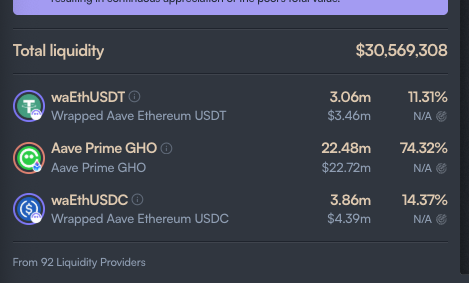

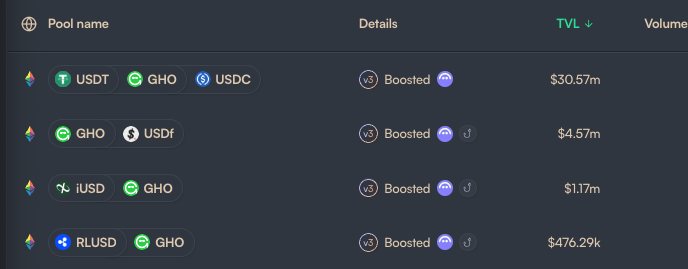

In [ ]:
# dex screener is not showing this as accurate it misses the othe rpools

# maybe aliaises, GHO -> stGHO, aGHO (manually)

In [ ]:
# it misses these pools

# sanity check, this is showing on mainnet that there is only 8.7M total in the other pair, and we currently own, 4.4M GHO,

that seems way too high

check balancer and curve 

In [ ]:
large_pairs_df[large_pairs_df["base_token_symbol"] == "GHO"]["usd_quote_liqudity"].sum().round()

In [ ]:
large_pairs_df["usd_quote_liqudity_thousands"] = large_pairs_df["usd_quote_liqudity"] / 1000
large_pairs_df["usd_base_liqudity_thousands"] = large_pairs_df["usd_base_liqudity"] / 1000

In [ ]:
large_pairs_df[large_pairs_df["base_token_symbol"] == "GHO"]["usd_quote_liqudity_thousands"].sum() * 1000
# this is

In [ ]:
large_pairs_df[large_pairs_df["base_token_symbol"] == "GHO"]

In [ ]:
prices[prices["token_address"] == "0x40D16FC0246aD3160Ccc09B8D0D3A2cD28aE6C2f"]

#

In [ ]:
sub_df.columns

In [ ]:
rows = [
    {"from_token": outer_k, "to_token": inner_k, "pair_liqudity": v}
    for outer_k, inner_dict in our_token_to_total_other_token_liquidity.items()
    for inner_k, v in inner_dict.items()
]

exit_liqudity_df = pd.DataFrame(rows)
exit_liqudity_df = exit_liqudity_df.groupby("from_token")["pair_liqudity"].sum().round().sort_values(ascending=False)
exit_liqudity_df

In [39]:
our_exposure = df.groupby("token_symbol")["quantity"].sum()


our_exposure_with_liquidity = exit_liqudity_df.to_frame().join(our_exposure, how="left")
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_white"

fig = px.bar(
    our_exposure_with_liquidity,
    x=our_exposure_with_liquidity.index,
    y=["pair_liqudity", "quantity"],
    title="Exit Liquidity vs Our Exposure",
)

fig.update_layout(barmode="group")  # Ensures bars are side-by-side
fig.show()

NameError: name 'df' is not defined

imo we are find to ignore the uniswap v4 pools, mostly for ETH and BTC and USDC and USDT already very very liqudity pools

https://app.uniswap.org/explore/pools/ethereum

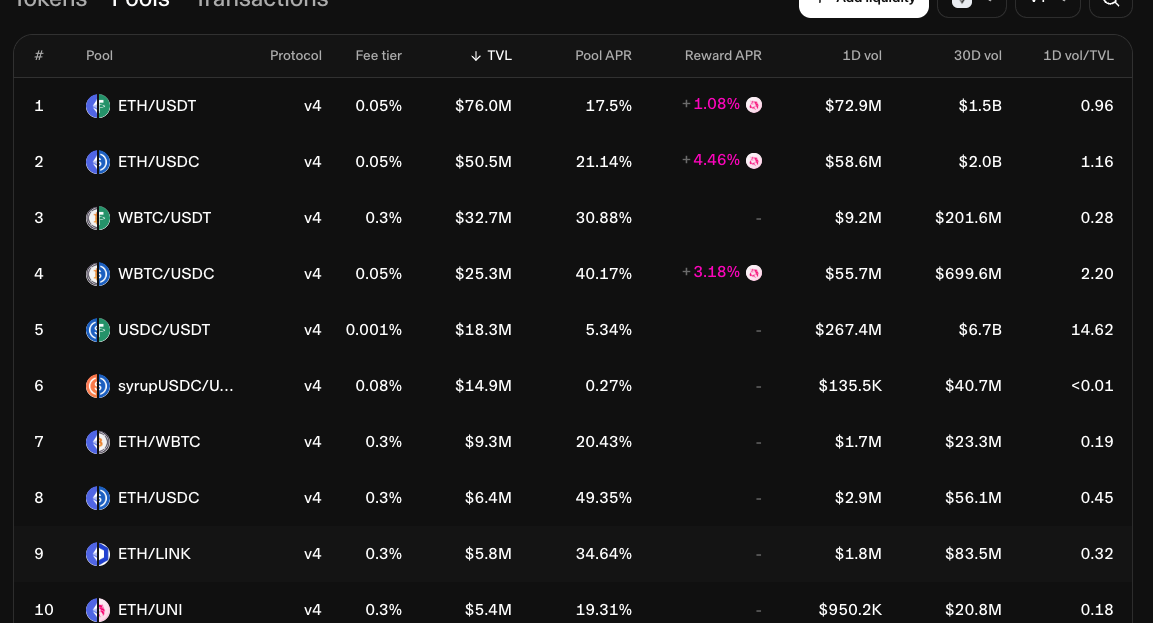